#  Tutorial on Bayesian parameter inference.

In [1]:
# Important libraries to import
# Scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('deep')
# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

## Exploratory data analysis and the power of Pandas

In [2]:
# Read the tidy data frame
df = pd.read_csv('../../data/flow_master.csv', comment='#')

df.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
0,20160804,mrazomej,O2,-13.9,auto,0,0.0,3512.623320,0.000000,0.000000
1,20160804,mrazomej,O2,-13.9,delta,0,0.0,19164.225851,15651.602531,1.000000
2,20160804,mrazomej,O2,-13.9,RBS1L,870,0.0,3624.474605,111.851286,0.007146
3,20160804,mrazomej,O2,-13.9,RBS1,610,0.0,3619.786265,107.162946,0.006847
4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059


##  Boolean indexing

In [3]:
df.repressors == 130

0       False
1       False
2       False
3       False
4        True
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12       True
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20       True
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28       True
29      False
        ...  
2828    False
2829    False
2830     True
2831    False
2832    False
2833    False
2834    False
2835    False
2836    False
2837    False
2838     True
2839    False
2840    False
2841    False
2842    False
2843    False
2844    False
2845    False
2846     True
2847    False
2848    False
2849    False
2850    False
2851    False
2852    False
2853    False
2854     True
2855    False
2856    False
2857    False
Name: repressors, dtype: bool

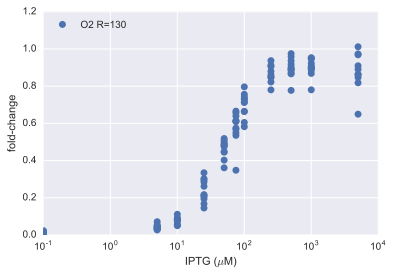

In [4]:
df_O2_130 = df[(df.repressors==130) & (df.operator=='O2')]

plt.semilogx(df_O2_130.IPTG_uM, df_O2_130.fold_change_A, 
            linewidth=0, marker='o', label='O2 R=130')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')

# Definig  fold-change functions

In [5]:
# define a funciton to compute the fold change as a funciton of IPTG
def pact(IPTG, ea, ei, epsilon=4.5):
    '''
    Returns the probability of a repressor being active as described by the MWC
    model.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    ea, ei : float.
        minus log of the dissociation constants of the active and the inactive 
        states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    Returns
    -------
    pact : float.
        probability of a repressor of being in the active state. Active state is
        defined as the state that can bind to the DNA.
    '''
    pact = (1 + IPTG * np.exp(-ea))**2 / \
    ((1 + IPTG * np.exp(-ea))**2 + np.exp(-epsilon) * (1 + IPTG * np.exp(-ei))**2)
    return pact

def fold_change(IPTG, ea, ei, epsilon, R, epsilon_r):
    '''
    Returns the gene expression fold change according to the thermodynamic model
    with the extension that takes into account the effect of the inducer.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    ea, ei : float.
        minus log of the dissociation constants of the active and the inactive 
        states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    R : array-like.
        repressor copy number for each of the strains. The length of this array
        should be equal to the IPTG array. If only one value of the repressor is
        given it is asssume that all the data points should be evaluated with
        the same repressor copy number
    epsilon_r : array-like
        repressor binding energy. The length of this array
        should be equal to the IPTG array. If only one value of the binding
        energy is given it is asssume that all the data points 
        should be evaluated with the same repressor copy number
        
    Returns
    -------
    fold-change : float.
        gene expression fold change as dictated by the thermodynamic model.
   '''
    return 1 / (1 + 2 * R / 5E6 * pact(IPTG, ea, ei, epsilon) * \
            (1 + np.exp(-epsilon)) * np.exp(-epsilon_r))

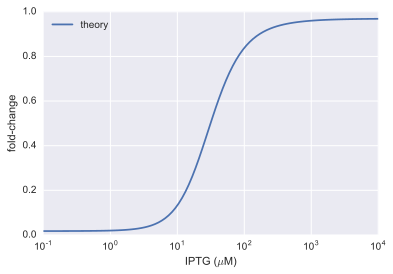

In [6]:
# Define the list of parameters we are going to need
R = df_O2_130.repressors.unique() #repressors/cell
epsilon_r = df_O2_130.binding_energy.unique() #kBT
epsilon = 4.5 #kBT
ea = 5 #kBT
ei = -1

# Define range of IPTG
IPTG = np.logspace(-1, 4, 100)

# Compute fold change with these parameters
fc = fold_change(IPTG=IPTG, ea=ea, ei=ei, epsilon=epsilon, epsilon_r=epsilon_r,
                 R=R)

# Plot the theoretical fold change
plt.semilogx(IPTG, fc, label='theory')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')

In [7]:
def log_post(param, indep_var, dep_var):
    '''
    Computes the log posterior for a single set of parameters.
    Parameters
    ----------
    param : array-like.
        param[0] = epsilon_a
        param[1] = epsilon_i
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
        
    Returns
    -------
    log_post : float.
        the log posterior probability
    '''
    # unpack parameters
    ea, ei = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var[:, 0], indep_var[:, 1], indep_var[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = fold_change(IPTG, ea, ei, 4.5, R, epsilon_r)
    
    # return the log posterior
    return -len(dep_var) / 2 * np.log(np.sum((dep_var - fc_theory)**2))

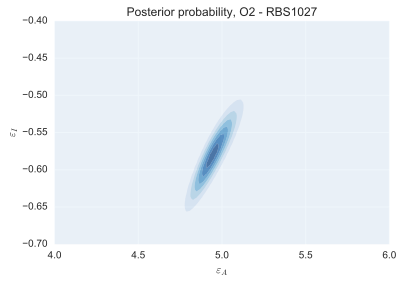

In [8]:
# Parameter values to plot
ea = np.linspace(4, 6, 100)
ei = np.linspace(-0.4, -0.7, 100)

# make a grid to plot
ea_grid, ei_grid = np.meshgrid(ea, ei)

# compute the log posterior
indep_var = df_O2_130[['IPTG_uM', 'repressors', 'binding_energy']]
dep_var = df_O2_130.fold_change_A

log_posterior = np.empty_like(ea_grid)
for i in range(len(ea)):
    for j in range(len(ei)):
        log_posterior[i, j] = log_post([ea_grid[i, j], ei_grid[i, j]],
                                       indep_var.values, dep_var.values)

# Get things to scale better
log_posterior -= log_posterior.max()

# plot the results
plt.figure()
plt.contourf(ea_grid, ei_grid, np.exp(log_posterior), alpha=0.7,
             cmap=plt.cm.Blues)
plt.xlabel(r'$\varepsilon_A$')
plt.ylabel(r'$\varepsilon_I$')
plt.title('Posterior probability, O2 - RBS1027')

###  Finding the most probable parameters.

In order to compute the most likely parameter values we will use the `scipy.optimize.leastsq()` function.
For this we need to define a function that computes the residuals.

In [9]:
def resid(param, indep_var, dep_var, epsilon=4.5):
    '''
    Residuals for the theoretical fold change.
    
    Parameters
    ----------
    param : array-like.
        param[0] = epsilon_a
        param[1] = epsilon_i
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
        
    Returns
    -------
    fold-change_exp - fold-change_theory
    '''
    # unpack parameters
    ea, ei = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var[:, 0], indep_var[:, 1], indep_var[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = fold_change(IPTG, ea, ei, epsilon, R, epsilon_r)
    
    # return the log posterior
    return dep_var - fc_theory

In [10]:
# Initial guess
p0 = np.array([5, -.55]) # From plotting the posterior

# Extra arguments given as tuple 
args = (indep_var.values, dep_var.values)

# Compute the MAP 
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

# Extract the values
ea, ei = popt

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} uM
Ki = {1:.3f} uM
""".format(np.exp(ea), np.exp(ei)))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 140.38 uM
Ki = 0.560 uM



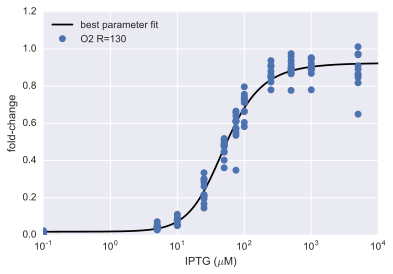

In [11]:
IPTG = np.logspace(-1, 4, 200)
fc_theory = fold_change(IPTG, ea, ei, 4.5, R=130, epsilon_r=-13.9)

plt.semilogx(IPTG, fc_theory, label='best parameter fit', color='black')
plt.semilogx(df_O2_130.IPTG_uM, df_O2_130.fold_change_A, 
            linewidth=0, marker='o', label='O2 R=130')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')

##  Computing an error-bar for the parameters.

In [12]:
# import library to compute the Hessian matrix
import statsmodels.tools.numdiff as smnd 

Computing the Hessian matrix

In [13]:
# list the arguments to be fed to the log_post function
args = (indep_var.values, dep_var.values)

# Compute the Hessian at the map
hes = smnd.approx_hess(popt, log_post, args=args)
hes

array([[ -623.2508201 ,  1291.19018354],
       [ 1291.19018354, -3351.48030028]])

Invert this matrix

In [14]:
# Compute the covariance matrix
cov = -np.linalg.inv(hes) 
cov

array([[ 0.00794866,  0.0030623 ],
       [ 0.0030623 ,  0.00147816]])